Loading input files...
Building ML-ready dataset...


Processing users: 100%|██████████| 53/53 [00:20<00:00,  2.64it/s]


Running walk-forward modeling...


Walk-forward trials: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]



Average accuracy: 0.7250


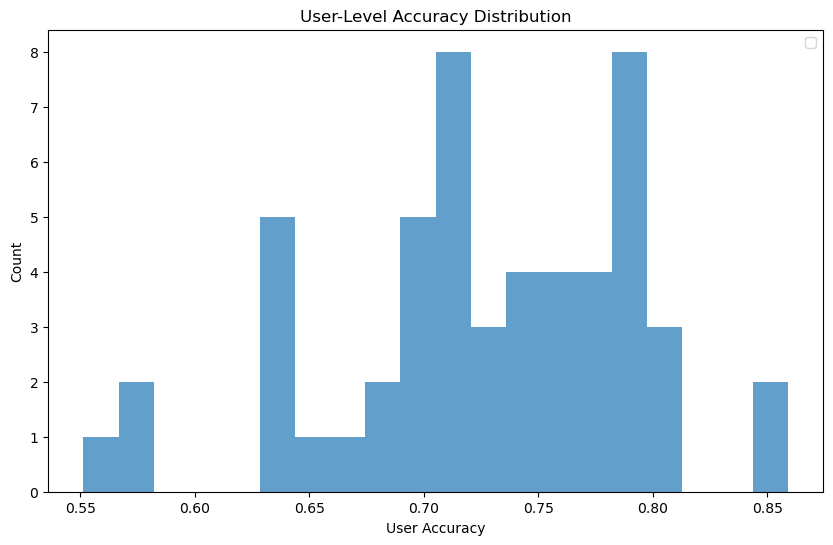

Performing SHAP analysis...


SHAP analysis: 100%|██████████| 39/39 [00:02<00:00, 14.61it/s]



Overall Strategy Composition (Mean SHAP Values):
QRL: 0.2089
RItem: 0.3384
RCat: 0.1730
LSC: 0.1941
WSLS: 0.1908
EV: 0.3542
RA: 0.0899
RS: 0.2255
PD: 0.4436


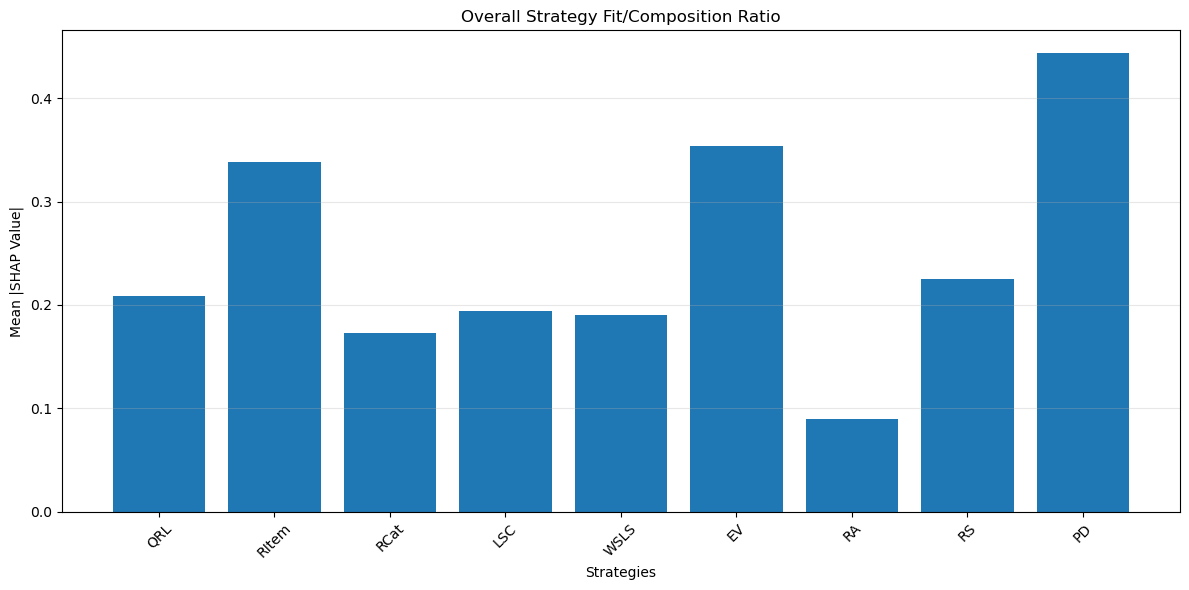

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re

# Check for optional libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available; falling back to RandomForest.")

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available; skipping SHAP-related analyses.")

warnings.filterwarnings('ignore')

# Define category mappings based on Strategy_fit_degree
ITEM_TO_CATEGORY_MAP = {
    'PURPLE': 'Colour', 'BLUE': 'Colour', 'GREEN': 'Colour', 'RED': 'Colour', 'ORANGE': 'Colour',
    'RISK': 'Concept', 'HOPE': 'Concept', 'SAFETY': 'Concept', 'VITALITY': 'Concept', 'POWER': 'Concept',
    'LITERATURE': 'Discipline', 'PHYSICS': 'Discipline', 'MUSIC': 'Discipline', 'HISTORY': 'Discipline', 'GEOGRAPHY': 'Discipline',
    'SEA': 'Place', 'DESERT': 'Place', 'CITY': 'Place', 'MOUNTAIN': 'Place', 'VILLAGE': 'Place'
}

CATEGORY_TO_ITEMS_MAP = {
    'Colour': ['PURPLE', 'BLUE', 'GREEN', 'RED', 'ORANGE'],
    'Concept': ['RISK', 'HOPE', 'SAFETY', 'VITALITY', 'POWER'],
    'Discipline': ['LITERATURE', 'PHYSICS', 'MUSIC', 'HISTORY', 'GEOGRAPHY'],
    'Place': ['SEA', 'DESERT', 'CITY', 'MOUNTAIN', 'VILLAGE']
}

# Load input files
def load_inputs(questions_file='questions.xlsx', preferences_file='perference_transformed.csv', decisions_file='decision.csv'):
    df_questions = pd.read_excel(questions_file, header=None)
    df_questions.columns = ['question_id', 'options_str']  # Assuming first column is question_num, second is options string
    
    # Parse options from string like "PURPLE - 4, RISK - 3, LITERATURE - 2, SEA - 1"
    def parse_options(row):
        matches = re.findall(r'([A-Z]+) - (\d+)', row['options_str'])
        return pd.Series({opt.upper(): int(score) for opt, score in matches})
    
    options_df = df_questions.apply(parse_options, axis=1)
    df_questions = pd.concat([df_questions['question_id'], options_df], axis=1)
    
    df_preferences = pd.read_csv(preferences_file)
    df_decisions = pd.read_csv(decisions_file, header=None)
    df_decisions.columns = ['user_id', 'question_id', 'chosen_item', 'score']
    
    return df_decisions, df_preferences, df_questions

# Strategy implementations based on Strategy_fit_degree.ipynb
def compute_strategy_predictions(user_id, df_questions, df_preferences, df_decisions_user):
    user_pref = df_preferences.iloc[user_id-1].to_dict() if user_id <= len(df_preferences) else {}
    
    # Prepare questions and scores dataframes as in Strategy_fit_degree
    questions = pd.DataFrame(columns=['Question', 'Colour', 'Concept', 'Discipline', 'Place'])
    scores = pd.DataFrame(columns=['Question', 'Colour', 'Concept', 'Discipline', 'Place'])
    
    for _, row in df_questions.iterrows():
        qid = row['question_id']
        opts = {col: row[col] for col in row.index if col != 'question_id' and pd.notna(row[col])}
        question_row = {'Question': qid}
        score_row = {'Question': qid}
        for cat in ['Colour', 'Concept', 'Discipline', 'Place']:
            for item, score in opts.items():
                if item in CATEGORY_TO_ITEMS_MAP[cat]:
                    question_row[cat] = item
                    score_row[cat] = score
                    break
        questions = pd.concat([questions, pd.DataFrame([question_row])], ignore_index=True)
        scores = pd.concat([scores, pd.DataFrame([score_row])], ignore_index=True)
    
    # Convert types
    scores.iloc[:, 1:] = scores.iloc[:, 1:].astype(int)
    
    # Function to get current options
    def get_current_options(row, scores, index):
        return {
            'Colour': (row['Colour'], scores.iloc[index]['Colour']),
            'Concept': (row['Concept'], scores.iloc[index]['Concept']),
            'Discipline': (row['Discipline'], scores.iloc[index]['Discipline']),
            'Place': (row['Place'], scores.iloc[index]['Place'])
        }
    
    # Strategy functions (adapted to return predicted items for each question)
    def strategy_q_rl(questions, scores):
        predicted = {}
        learning_rate = 0.1
        discount_factor = 0.9
        all_options = set(ITEM_TO_CATEGORY_MAP.keys())
        q_values = {opt: 0 for opt in all_options}
        
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            options_with_q = [(opt, q_values[opt]) for opt, _ in current_options.values()]
            max_q = max(q for _, q in options_with_q) if options_with_q else 0
            best_items = [opt for opt, q in options_with_q if q == max_q]
            predicted[qid] = best_items
            
            # Update Q-values
            for opt, score in current_options.values():
                old_q = q_values[opt]
                max_future_q = max(q_values[o] for o, _ in current_options.values()) if current_options else 0
                new_q = old_q + learning_rate * (score + discount_factor * max_future_q - old_q)
                q_values[opt] = new_q
        
        return predicted
    
    def strategy_r_item(questions, scores):
        predicted = {}
        history = {}
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            if not any(opt in history for opt, _ in current_options.values()):
                best_items = [opt for opt, _ in current_options.values()]
            else:
                options_with_history = [(opt, history.get(opt, 0)) for opt, _ in current_options.values() if opt in history]
                max_score = max(s for _, s in options_with_history) if options_with_history else 0
                best_items = [opt for opt, s in options_with_history if s == max_score]
            predicted[qid] = best_items
            
            for opt, score in current_options.values():
                history[opt] = score
        return predicted
    
    def strategy_r_cat(questions, scores):
        predicted = {}
        history = {}
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            if not any(cat in history for cat in current_options):
                best_cats = list(current_options.keys())
            else:
                cats_with_history = [(cat, history[cat]) for cat in current_options if cat in history]
                max_score = max(s for _, s in cats_with_history) if cats_with_history else 0
                best_cats = [cat for cat, s in cats_with_history if s == max_score]
            best_items = [current_options[cat][0] for cat in best_cats]
            predicted[qid] = best_items
            
            for cat, (_, score) in current_options.items():
                history[cat] = score
        return predicted
    
    def strategy_lsc(questions, scores, df_decisions_user):
        predicted = {}
        selection_count = {cat: 0 for cat in CATEGORY_TO_ITEMS_MAP}
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            min_count = min(selection_count.values())
            least_selected = [cat for cat in current_options if selection_count[cat] == min_count]
            best_items = [current_options[cat][0] for cat in least_selected]
            predicted[qid] = best_items
            
            # Update with actual choice (for simulation)
            actual_choice = df_decisions_user[df_decisions_user['question_id'] == qid]['chosen_item'].values[0]
            cat = ITEM_TO_CATEGORY_MAP.get(actual_choice.upper(), None)
            if cat:
                selection_count[cat] += 1
        return predicted
    
    def strategy_wsls(questions, scores, df_decisions_user):
        predicted = {}
        valid_cats = list(CATEGORY_TO_ITEMS_MAP.keys())
        best_cats = valid_cats
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            best_items = [current_options[cat][0] for cat in best_cats]
            predicted[qid] = best_items
            
            actual_choice = df_decisions_user[df_decisions_user['question_id'] == qid]['chosen_item'].values[0]
            cat = ITEM_TO_CATEGORY_MAP.get(actual_choice.upper(), None)
            score = current_options[cat][1] if cat else 0
            if score < 3:
                best_cats = [c for c in valid_cats if c != cat]
            else:
                best_cats = [cat]
        return predicted
    
    def strategy_ev(questions, scores):
        predicted = {}
        expectations = {}  # {item: (total, count)}
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            options_with_exp = []
            for opt, score in current_options.values():
                total, count = expectations.get(opt, (0, 0))
                avg = total / count if count > 0 else 0
                options_with_exp.append((opt, avg))
            max_avg = max(a for _, a in options_with_exp) if options_with_exp else 0
            best_items = [opt for opt, a in options_with_exp if a == max_avg]
            predicted[qid] = best_items
            
            for opt, score in current_options.values():
                total, count = expectations.get(opt, (0, 0))
                expectations[opt] = (total + score, count + 1)
        return predicted
    
    def strategy_ra(questions, scores):
        predicted = {}
        score_history = defaultdict(list)
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            options_with_var = []
            for opt, score in current_options.values():
                s = score_history[opt]
                if len(s) > 1:
                    mean = np.mean(s)
                    std = np.std(s)
                    val = mean - std
                else:
                    val = 0
                options_with_var.append((opt, val))
            max_val = max(v for _, v in options_with_var) if options_with_var else 0
            best_items = [opt for opt, v in options_with_var if v == max_val]
            predicted[qid] = best_items
            
            for opt, score in current_options.values():
                score_history[opt].append(score)
        return predicted
    
    def strategy_rs(questions, scores):
        predicted = {}
        score_history = defaultdict(list)
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            options_with_var = []
            for opt, score in current_options.values():
                s = score_history[opt]
                if len(s) > 1:
                    mean = np.mean(s)
                    std = np.std(s)
                    val = mean + std
                else:
                    val = 0
                options_with_var.append((opt, val))
            max_val = max(v for _, v in options_with_var) if options_with_var else 0
            best_items = [opt for opt, v in options_with_var if v == max_val]
            predicted[qid] = best_items
            
            for opt, score in current_options.values():
                score_history[opt].append(score)
        return predicted
    
    def strategy_pd(questions, scores, user_pref):
        predicted = {}
        for idx, row in questions.iterrows():
            qid = row['Question']
            current_options = get_current_options(row, scores, idx)
            prefs = [(opt, user_pref.get(opt, 0)) for opt, _ in current_options.values()]
            max_pref = max(p for _, p in prefs) if prefs else 0
            best_items = [opt for opt, p in prefs if p == max_pref]
            predicted[qid] = best_items
        return predicted
    
    # Compute predictions for all strategies
    strat_preds = {
        'QRL': strategy_q_rl(questions, scores),
        'RItem': strategy_r_item(questions, scores),
        'RCat': strategy_r_cat(questions, scores),
        'LSC': strategy_lsc(questions, scores, df_decisions_user),
        'WSLS': strategy_wsls(questions, scores, df_decisions_user),
        'EV': strategy_ev(questions, scores),
        'RA': strategy_ra(questions, scores),
        'RS': strategy_rs(questions, scores),
        'PD': strategy_pd(questions, scores, user_pref)
    }
    
    return strat_preds

# Build ML-ready dataset (per option row)
def build_ml_ready_dataset(df_decisions, df_preferences, df_questions):
    ml_rows = []
    
    for user_id in tqdm(df_decisions['user_id'].unique(), desc="Processing users"):
        df_user_dec = df_decisions[df_decisions['user_id'] == user_id]
        strat_preds = compute_strategy_predictions(user_id, df_questions, df_preferences, df_user_dec)
        
        for _, q_row in df_questions.iterrows():
            qid = q_row['question_id']
            options = {col.upper(): q_row[col] for col in q_row.index if col != 'question_id' and pd.notna(q_row[col])}
            
            chosen_item = df_user_dec[df_user_dec['question_id'] == qid]['chosen_item'].values
            chosen_item = chosen_item[0].upper() if len(chosen_item) > 0 else None
            
            for item in options:
                row = {
                    'user_id': user_id,
                    'question_id': qid,
                    'item': item,
                    'payoff': options[item],
                    'category': ITEM_TO_CATEGORY_MAP.get(item, None),
                    'preference': df_preferences.iloc[user_id-1][item] if user_id <= len(df_preferences) else 0,
                    'is_chosen': 1 if item == chosen_item else 0
                }
                
                # Add strategy signals: 1 if item is in strategy's predicted best for this question
                for strat, preds in strat_preds.items():
                    signal_col = f'Signal_{strat}'
                    row[signal_col] = 1 if item in preds.get(qid, []) else 0
                
                # Add other features (e.g., trial number, accumulated score, etc.)
                row['trial_number'] = qid
                prev_trials = df_user_dec[df_user_dec['question_id'] < qid]
                row['accumulated_score'] = prev_trials['score'].sum() if 'score' in prev_trials.columns else 0
                row['prev_outcome_win'] = 1 if len(prev_trials) > 0 and prev_trials.iloc[-1]['score'] >= 3 else 0  # Assuming win if score >=3
                
                ml_rows.append(row)
    
    ml_df = pd.DataFrame(ml_rows)
    return ml_df

# Walk-forward prediction
def walk_forward_predict_and_evaluate(ml_df, feature_cols, model_type='xgboost'):
    trial_accs = {}
    per_trial_models = {}
    preds = []
    
    unique_trials = sorted(ml_df['trial_number'].unique())
    
    for i in tqdm(range(1, len(unique_trials)), desc="Walk-forward trials"):
        train_trials = unique_trials[:i]
        test_trial = unique_trials[i]
        
        train_df = ml_df[ml_df['trial_number'].isin(train_trials)]
        test_df = ml_df[ml_df['trial_number'] == test_trial]
        
        if len(train_df) == 0 or len(test_df) == 0:
            continue
        
        X_train = train_df[feature_cols]
        y_train = train_df['is_chosen']
        X_test = test_df[feature_cols]
        y_test = test_df['is_chosen']
        
        if model_type == 'xgboost' and XGBOOST_AVAILABLE:
            model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
        else:
            model = RandomForestClassifier(random_state=42, n_jobs=-1)
        
        model.fit(X_train, y_train)
        per_trial_models[test_trial] = model
        
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        test_df['pred_prob'] = y_pred_prob
        test_df['pred_chosen'] = 0
        
        # Predict per user: choose item with highest prob
        for user in test_df['user_id'].unique():
            user_df = test_df[test_df['user_id'] == user]
            if len(user_df) > 0:
                pred_item_idx = user_df['pred_prob'].idxmax()
                test_df.loc[pred_item_idx, 'pred_chosen'] = 1
        
        acc = accuracy_score(test_df['is_chosen'], test_df['pred_chosen'])
        trial_accs[test_trial] = acc
        preds.append(test_df)
    
    preds_df = pd.concat(preds)
    acc_df = pd.DataFrame(list(trial_accs.items()), columns=['trial', 'accuracy'])
    
    return trial_accs, per_trial_models, preds_df, acc_df

# SHAP analysis
def shap_analysis(per_trial_models, ml_df, feature_cols):
    shap_summary = []
    
    for trial, model in tqdm(per_trial_models.items(), desc="SHAP analysis"):
        test_df = ml_df[ml_df['trial_number'] == trial]
        X_test = test_df[feature_cols]
        
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # For binary classification
            
            trial_shap = {'trial_number': trial}
            for i, f in enumerate(feature_cols):
                trial_shap[f] = np.abs(shap_values[:, i]).mean()
            shap_summary.append(trial_shap)
    
    shap_df = pd.DataFrame(shap_summary).sort_values('trial_number')
    strategy_feats = [f for f in feature_cols if f.startswith('Signal_')]
    
    # Overall composition ratio
    if not shap_df.empty:
        mean_shap = shap_df[strategy_feats].mean()
        strategy_names = [f.replace('Signal_', '') for f in strategy_feats]
        
        print("\nOverall Strategy Composition (Mean SHAP Values):")
        for name, value in zip(strategy_names, mean_shap):
            print(f"{name}: {value:.4f}")
        
        plt.figure(figsize=(12, 6))
        plt.bar(strategy_names, mean_shap)
        plt.xlabel('Strategies')
        plt.ylabel('Mean |SHAP Value|')
        plt.title('Overall Strategy Fit/Composition Ratio')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    return shap_df

# Main function
def main():
    print("Loading input files...")
    df_decisions, df_preferences, df_questions = load_inputs()
    
    print("Building ML-ready dataset...")
    ml_df = build_ml_ready_dataset(df_decisions, df_preferences, df_questions)
    
    feature_cols = [
        'payoff', 'preference', 'accumulated_score', 'trial_number', 'prev_outcome_win',
        'Signal_QRL', 'Signal_RItem', 'Signal_RCat', 'Signal_LSC', 'Signal_WSLS',
        'Signal_EV', 'Signal_RA', 'Signal_RS', 'Signal_PD'
    ]
    
    print("Running walk-forward modeling...")
    trial_accs, per_trial_models, preds_df, acc_df = walk_forward_predict_and_evaluate(ml_df, feature_cols)
    
    avg_acc = np.mean(list(trial_accs.values()))
    print(f"\nAverage accuracy: {avg_acc:.4f}")
    
    # User accuracy distribution with baseline
    user_acc = preds_df.groupby('user_id').apply(lambda g: accuracy_score(g['is_chosen'], g['pred_chosen']))
    plt.figure(figsize=(10,6))
    plt.hist(user_acc, bins=20, alpha=0.7)
    plt.xlabel('User Accuracy')
    plt.ylabel('Count')
    plt.title('User-Level Accuracy Distribution')
    plt.legend()
    plt.show()
    
    if SHAP_AVAILABLE:
        print("Performing SHAP analysis...")
        shap_df = shap_analysis(per_trial_models, ml_df, feature_cols)
    else:
        shap_df = None

if __name__ == "__main__":
    main()